In [165]:
import os
import numpy as np
from functools import partial
import math
from tqdm import tqdm
import time as time

import torch
M1 = False

if M1:
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
else:
    os.environ["CUDA_VISIBLE_DEVICES"]="2"
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if torch.cuda.is_available():
        print(torch.cuda.is_available())
        print(torch.cuda.device_count())
        print(torch.cuda.current_device())
        print(torch.cuda.get_device_name(torch.cuda.current_device()))


from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from torchmetrics.functional import structural_similarity_index_measure 
from torchmetrics.functional import peak_signal_noise_ratio 

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches
import matplotlib.ticker as tick

import scipy.io as sio
import scipy as sp
from astropy.io import fits
from skimage import transform

import large_scale_UQ as luq
from large_scale_UQ.utils import to_numpy, to_tensor
from convex_reg import utils as utils_cvx_reg


True
1
0
NVIDIA A100-PCIE-40GB


In [154]:
# Save param
repo_dir = '/disk/xray0/tl3/repos/large-scale-UQ'
base_savedir = '/disk/xray0/tl3/outputs/large-scale-UQ/sampling/CRR'
save_dir = base_savedir + '/vars/'
savefig_dir = base_savedir + '/hypothesis_test_figs/'

img_name_list = ['CYN', 'M31', '3c288', '3c288','W28']
pysiscal_list = [True, True, True, False, True]

alpha_prob = 0.01

map_potential_list = []
surrogate_potential_list = []
gamma_alpha_list = []
Hnot_reject_list = []
potential_blurring_list = []
Hnot_reject_blurring_list = []

load_var_dir = '/disk/xray0/tl3/outputs/large-scale-UQ/def_UQ_results/CRR/vars/'

cmap = 'cubehelix'
model_prefix = '-CRR'

map_vars_path_arr = [
    load_var_dir+'CYN_CRR_UQ_MAP_lmbd_5.0e+04_MAP_vars.npy',
    load_var_dir+'M31_CRR_UQ_MAP_lmbd_5.0e+04_MAP_vars.npy',
    load_var_dir+'3c288_CRR_UQ_MAP_lmbd_5.0e+04_MAP_vars.npy',
    load_var_dir+'3c288_CRR_UQ_MAP_lmbd_5.0e+04_MAP_vars.npy',
    load_var_dir+'W28_CRR_UQ_MAP_lmbd_5.0e+04_MAP_vars.npy',
]
samp_vars_path_arr = [
    load_var_dir+'CYN_SKROCK_CRR_lmbd_5.0e+04_mu_2.0e+01_nsamples_5.0e+04_thinning_1.0e+01_vars.npy',
    load_var_dir+'M31_SKROCK_CRR_lmbd_5.0e+04_mu_2.0e+01_nsamples_5.0e+04_thinning_1.0e+01_vars.npy',
    load_var_dir+'3c288_SKROCK_CRR_lmbd_5.0e+04_mu_2.0e+01_nsamples_5.0e+04_thinning_1.0e+01_vars.npy',
    load_var_dir+'3c288_SKROCK_CRR_lmbd_5.0e+04_mu_2.0e+01_nsamples_5.0e+04_thinning_1.0e+01_vars.npy',
    load_var_dir+'W28_SKROCK_CRR_lmbd_5.0e+04_mu_2.0e+01_nsamples_5.0e+04_thinning_1.0e+01_vars.npy',    
]
img_name_arr = [
    'CYN',
    'M31',
    '3c288',
    '3c288',
    'W28',
]
vmin_log_arr = [
    -3.,
    -2.,
    -2.,
    -2.,
    -2.,
]

text_pos_arr = [
    [0, 0.08],
    [0, 0.04],
    [0, 0.04],
    [0, 0.04],
    [0, 0.04],
]
text_str_arr = [
    r'$1$',
    r'$1$',
    r'$1$',
    r'$2$',
    r'$1$'
]


In [155]:
# CRR load parameters
sigma_training = 5
t_model = 5
CRR_dir_name = '/disk/xray0/tl3/repos/convex_ridge_regularizers/trained_models/'
# CRR parameters
# reg_params = [5e4]
lmbd = 5e4
mu = 20


In [156]:


# Load CRR model
torch.set_grad_enabled(False)
torch.set_num_threads(4)

exp_name = f'Sigma_{sigma_training}_t_{t_model}/'
model = utils_cvx_reg.load_model(CRR_dir_name + exp_name, 'cuda:0', device_type='gpu')

print(f'Numbers of parameters before prunning: {model.num_params}')
model.prune()
print(f'Numbers of parameters after prunning: {model.num_params}')

# L_CRR = model.L.detach().cpu().squeeze().numpy()
# print(f"Lipschitz bound {L_CRR:.3f}")

# [not required] intialize the eigen vector of dimension (size, size) associated to the largest eigen value
model.initializeEigen(size=100)
# compute bound via a power iteration which couples the activations and the convolutions
model.precise_lipschitz_bound(n_iter=100)
# the bound is stored in the model
L_CRR = model.L.data.item()
print(f"Lipschitz bound {L_CRR:.3f}")


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 - linear_spline activation functions
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
Numbers of parameters before prunning: 13610
---------------------
 PRUNNING 
 Found 22 filters with non-vanishing potential functions
---------------------
Numbers of parameters after prunning: 4183
Lipschitz bound 0.770


In [157]:
it_img = 4
img_name = img_name_list[it_img]
map_vars_path = map_vars_path_arr[it_img]
samp_vars_path = samp_vars_path_arr[it_img]
vmin_log = vmin_log_arr[it_img]

text_pos = text_pos_arr[it_img]
textstr = text_str_arr[it_img]

# Load variables
map_vars = np.load(map_vars_path, allow_pickle=True)[()]
samp_vars = np.load(samp_vars_path, allow_pickle=True)[()]

# Load image and mask
img, mat_mask = luq.helpers.load_imgs(img_name, repo_dir)

# Define my torch types
myType = torch.float32
myComplexType = torch.complex64


In [158]:

# Aliases
x = img
ground_truth = img

torch_img = torch.tensor(
    np.copy(img), dtype=myType, device=device).reshape((1,1) + img.shape
)

phi = luq.operators.MaskedFourier_torch(
    shape=img.shape, 
    ratio=0.5 ,
    mask=mat_mask,
    norm='ortho',
    device=device
)


# Define X Cai noise level
sigma = 0.0024

y = phi.dir_op(torch_img).detach().cpu().squeeze().numpy()

# Generate noise
rng = np.random.default_rng(seed=0)
n = rng.normal(0, sigma, y[y!=0].shape)
# Add noise
y[y!=0] += n

# Observation
torch_y = torch.tensor(np.copy(y), device=device, dtype=myComplexType).reshape((1,) + img.shape)
x_init = torch.abs(phi.adj_op(torch_y))


# %%
# Define the likelihood
g = luq.operators.L2Norm_torch(
    sigma=sigma,
    data=torch_y,
    Phi=phi,
)
# Lipschitz constant computed automatically by g, stored in g.beta

# Define real prox
f = luq.operators.RealProx_torch()


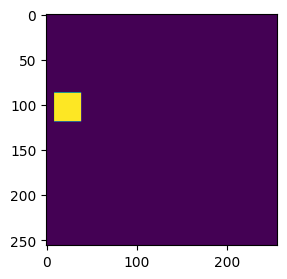

In [159]:
# Extract variables
x_gt = samp_vars['X_ground_truth']
x_dirty = samp_vars['X_dirty']
x_map = samp_vars['X_MAP']
x_mmse = samp_vars['X_MMSE']

# Inpainting
# x_map = np.copy(x_map)
pysiscal = pysiscal_list[it_img]
mask_x, mask_y = luq.helpers.get_hypothesis_test_mask(img_name, pysiscal)

np_mask_inpainting = np.zeros((img.shape[0], img.shape[1]))
np_mask_inpainting[mask_x[0]:mask_x[1], mask_y[0]:mask_y[1]] = 1

plt.figure(figsize=(3,3))
plt.imshow(np_mask_inpainting)
plt.show()


inpaint_img = np.copy(x_map)
inpaint_img[np_mask_inpainting.astype(bool)] = 0


mask_inpainting = torch.tensor(
    np_mask_inpainting, dtype=myType, device=device
).reshape((1,1) + img.shape)

x_init_imp = torch.tensor(
    inpaint_img, dtype=myType, device=device,
).reshape((1,1) + img.shape)



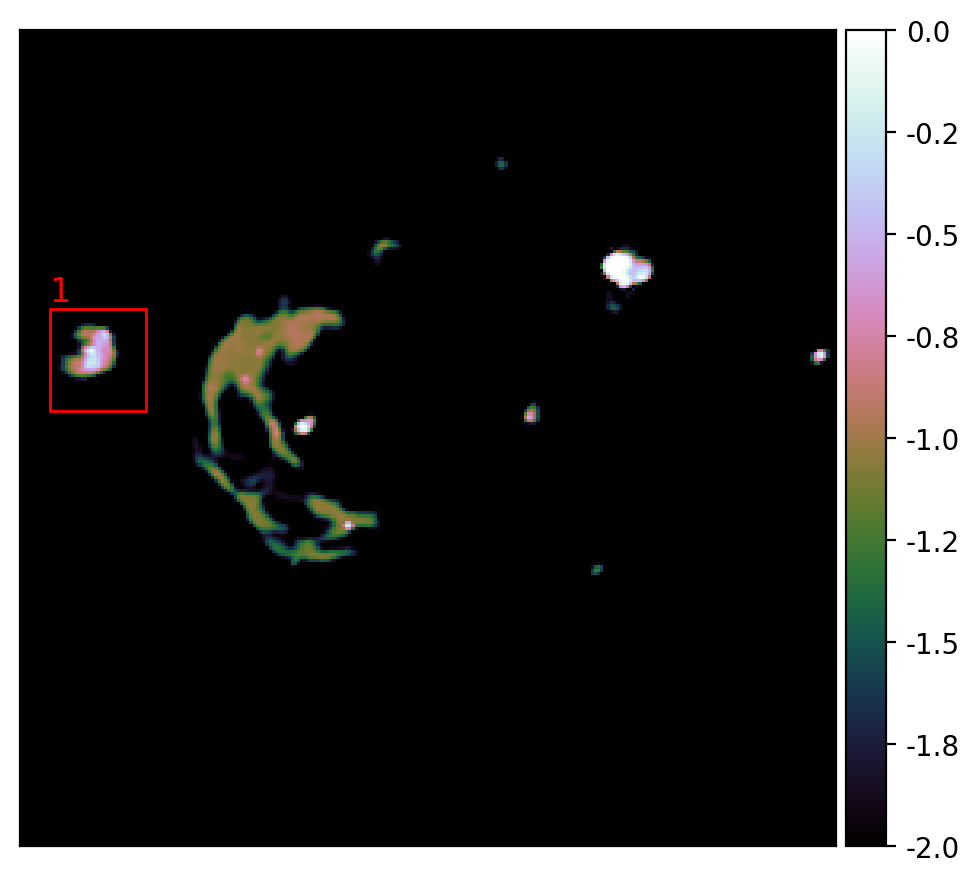

In [160]:
# Define rectangle coordinates
rect_anchor_xy = (mask_y[0], mask_x[0])
rect_width = mask_y[1] - mask_y[0]
rect_height = mask_x[1] - mask_x[0]
# Define text attributes
font = {
    'color':  'red',
    'weight': 'normal',
    'size': 12,
}

fig = plt.figure(figsize=(5,5), dpi=200)
axs = plt.gca()
plt_im = axs.imshow(np.log10(np.abs(x_map)), cmap=cmap, vmin=vmin_log, vmax=0)
divider = make_axes_locatable(axs)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(plt_im, cax=cax)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.1f'))
axs.set_yticks([]);axs.set_xticks([])

# Create a Rectangle patch
rect = patches.Rectangle(
    rect_anchor_xy, rect_width, rect_height,
    linewidth=1, edgecolor='r', facecolor='none'
)
# Add the patch to the Axes
axs.add_patch(rect)
axs.text(
    rect_anchor_xy[0]/x_map.shape[1] + text_pos[0],
    1 - rect_anchor_xy[1]/x_map.shape[0] + text_pos[1],
    textstr, transform=axs.transAxes, 
    fontdict=font, verticalalignment='top'
)
plt.tight_layout()
# plt.savefig(
#     '{:s}{:s}{:s}{:s}'.format(save_dir, img_name, model_prefix, '-MAP_image_inpaintedRegion.pdf'),
#     bbox_inches='tight',
#     dpi=200
# )
plt.show()


In [161]:

# Inpatinting
inptaint_options = {
    "tol": 5e-6,
    "iter": 15000,
    "update_iter": 10,
    "record_iters": False
}


x_map_torch = to_tensor(x_map)

# Compute stepsize
alpha = 0.98 / (g.beta + mu * lmbd * L_CRR)

# initialization
x_hat = torch.clone(x_init_imp)
z = torch.clone(x_init_imp)
t = 1

for it_2 in range(inptaint_options['iter']):
    x_hat_old = torch.clone(x_hat)
    
    # x_hat = z - alpha *(g.grad(z) + lmbd * model(mu * z))
    x_hat = z - alpha *lmbd * model(mu * z)
    # Positivity constraint
    x_hat = f.prox(x_hat)
    # Positivity constraint
    # x = torch.clamp(x, 0, None)

    x_hat = torch.clone(x_hat) * mask_inpainting + torch.clone(x_map_torch) * (1. - mask_inpainting)
    
    t_old = t 
    t = 0.5 * (1 + math.sqrt(1 + 4*t**2))
    z = x_hat + (t_old - 1)/t * (x_hat - x_hat_old)

    # relative change of norm for terminating
    res = (torch.norm(x_hat_old - x_hat)/torch.norm(x_hat_old)).item()

    if res < inptaint_options['tol']:
        print("[GD] converged in %d iterations"%(it_2))
        break

    if it_2 % inptaint_options['update_iter'] == 0:
        print(
            "[GD] %d out of %d iterations, tol = %f" %(            
                it_2,
                inptaint_options['iter'],
                res,
            )
        )



[GD] 0 out of 15000 iterations, tol = 0.000103
[GD] 10 out of 15000 iterations, tol = 0.000077
[GD] 20 out of 15000 iterations, tol = 0.000063
[GD] 30 out of 15000 iterations, tol = 0.000059
[GD] 40 out of 15000 iterations, tol = 0.000048
[GD] 50 out of 15000 iterations, tol = 0.000028
[GD] 60 out of 15000 iterations, tol = 0.000007
[GD] converged in 61 iterations


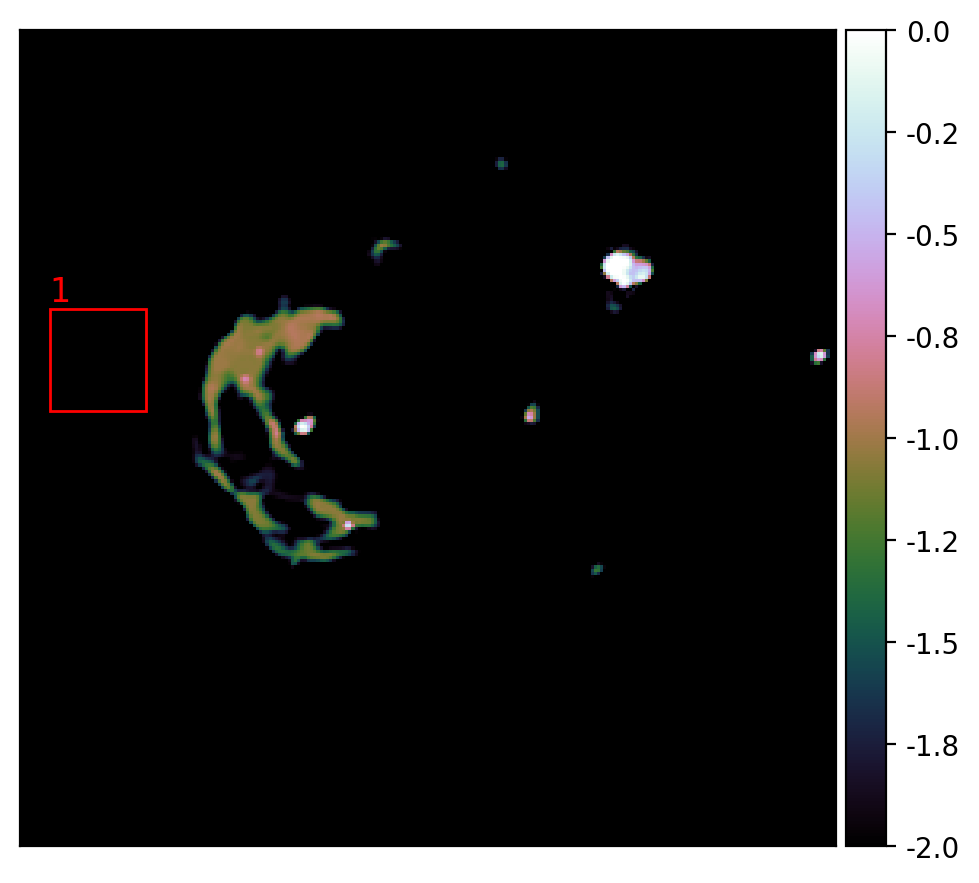

In [162]:
x_map_torch = to_tensor(x_map)

# Generate surrogate impainted img
surrogate_img = torch.clone(x_hat) * mask_inpainting + torch.clone(x_map_torch) * (1. - mask_inpainting)

imp_surrogate = to_numpy(torch.clone(surrogate_img))

# Define rectangle coordinates
rect_anchor_xy = (mask_y[0], mask_x[0])
rect_width = mask_y[1] - mask_y[0]
rect_height = mask_x[1] - mask_x[0]
# Define text attributes
font = {
    'color':  'red',
    'weight': 'normal',
    'size': 12,
}

fig = plt.figure(figsize=(5,5), dpi=200)
axs = plt.gca()
plt_im = axs.imshow(np.log10(np.abs(imp_surrogate)), cmap=cmap, vmin=vmin_log, vmax=0)
divider = make_axes_locatable(axs)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(plt_im, cax=cax)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.1f'))
axs.set_yticks([]);axs.set_xticks([])

# Create a Rectangle patch
rect = patches.Rectangle(
    rect_anchor_xy, rect_width, rect_height,
    linewidth=1, edgecolor='r', facecolor='none'
)
# Add the patch to the Axes
axs.add_patch(rect)
axs.text(
    rect_anchor_xy[0]/x_map.shape[1] + text_pos[0],
    1 - rect_anchor_xy[1]/x_map.shape[0] + text_pos[1],
    textstr, transform=axs.transAxes, 
    fontdict=font, verticalalignment='top'
)
plt.tight_layout()
# plt.savefig(
#     '{:s}{:s}{:s}{:s}'.format(save_dir, img_name, model_prefix, '-impaintedSurrogate_inpaintedRegion.pdf'),
#     bbox_inches='tight',
#     dpi=200
# )
plt.show()



In [164]:

#function handles to used for ULA
def _fun(_x, model, mu, lmbd):
    return (lmbd / mu) * model.cost(mu * _x) + g.fun(_x)

def _grad_fun(_x, g, model, mu, lmbd):
    return  torch.real(g.grad(_x) + lmbd * model(mu * _x))

def _prior_fun(_x, model, mu, lmbd):
    return (lmbd / mu) * model.cost(mu * _x)

# Evaluation of the potentials
fun = partial(_fun, model=model, mu=mu, lmbd=lmbd)
prior_fun = partial(_prior_fun, model=model, mu=mu, lmbd=lmbd)
# Evaluation of the gradient
grad_f = partial(_grad_fun, g=g, model=model, mu=mu, lmbd=lmbd)
# Evaluation of the potential in numpy
fun_np = lambda _x : fun(luq.utils.to_tensor(_x, dtype=myType)).item()

# Compute HPD region bound
N = x_map.size
tau_alpha = np.sqrt(16*np.log(3/alpha_prob))
gamma_alpha = fun(x_map_torch).item() + tau_alpha*np.sqrt(N) + N

print('gamma_alpha: ', gamma_alpha)
print('fun(x_map).item(): ', fun(x_map_torch).item())
print('tau_alpha*np.sqrt(N) + N: ', tau_alpha*np.sqrt(N) + N)


# Compute potential
map_potential = fun(x_map_torch).item()
potential = fun(surrogate_img).item()

if potential > gamma_alpha:
    print(img_name, ': Area nonremovable! (Reject H0)')
    Hnot_reject = True
else:
    print(img_name, ': Area removable! (Cannot reject H0)')
    Hnot_reject = False

print(img_name, '_gamma_alpha: ', gamma_alpha)
print(img_name, '_potential: ', potential)
print(img_name, '-MAP_potential: ', map_potential)

map_potential_list.append(map_potential)
surrogate_potential_list.append(potential)
gamma_alpha_list.append(gamma_alpha)
Hnot_reject_list.append(Hnot_reject)



gamma_alpha:  87562.19861493903
fun(x_map).item():  19580.62109375
tau_alpha*np.sqrt(N) + N:  67981.57752118903
W28 : Area nonremovable! (Reject H0)
W28 _gamma_alpha:  87562.19861493903
W28 _potential:  434436.09375
W28 -MAP_potential:  19580.62109375


In [166]:

x_map.shape



(256, 256)

# Hypothesis testing of image structure blurred


In [191]:


G_sigma = 2 # 1.02

gauss_blurred_im_np = sp.ndimage.gaussian_filter(
    input=np.copy(x_map),
    sigma=G_sigma,
    radius=np.int64(np.floor(2*G_sigma)),
)
gauss_blurred_im = to_tensor(gauss_blurred_im_np)


# Compute potential
potential_blurring = fun(gauss_blurred_im).item()

if potential_blurring > gamma_alpha:
    print(img_name, ': Blurred structure is physical! (Reject H0)')
    Hnot_reject_blurring = True
else:
    print(img_name, ': Cannot conclude if blurred structure is physical! (Cannot reject H0)')
    Hnot_reject_blurring = False

print(img_name, '_gamma_alpha: ', gamma_alpha)
print(img_name, '_potential_blurring: ', potential_blurring)
print(img_name, '-MAP_potential: ', map_potential)

potential_blurring_list.append(potential_blurring)
Hnot_reject_blurring_list.append(Hnot_reject_blurring)


W28 : Blurred structure is physical! (Reject H0)
W28 _gamma_alpha:  87562.19861493903
W28 _potential_blurring:  324216.5
W28 -MAP_potential:  19580.62109375


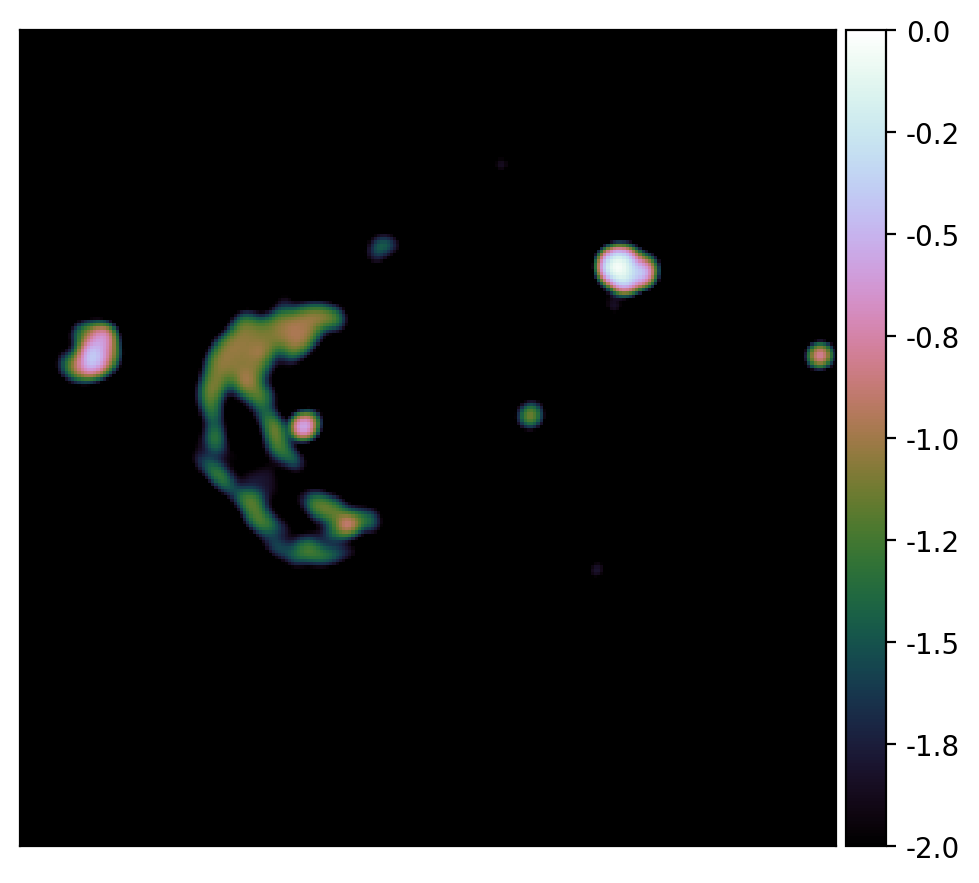

In [194]:

fig = plt.figure(figsize=(5,5), dpi=200)
axs = plt.gca()
plt_im = axs.imshow(np.log10(np.abs(to_numpy(gauss_blurred_im))), cmap=cmap, vmin=vmin_log, vmax=0)
divider = make_axes_locatable(axs)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(plt_im, cax=cax)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.1f'))
axs.set_yticks([]);axs.set_xticks([])
plt.tight_layout()
# plt.savefig(
#     '{:s}{:s}{:s}{:s}{:.2f}{:s}'.format(save_dir, img_name, model_prefix, '-blurred_surrogate_image_Gsigma_', G_sigma, '.pdf'),
#     bbox_inches='tight',
#     dpi=200
# )
plt.show()



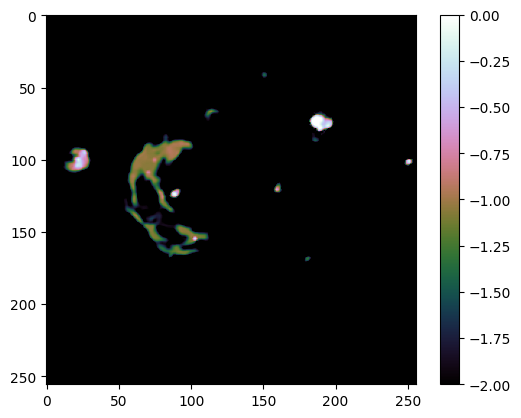

/tmp/ipykernel_1365504/2649534185.py:9: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(np.abs(img)), cmap=cmap, vmax=0, vmin=-2)


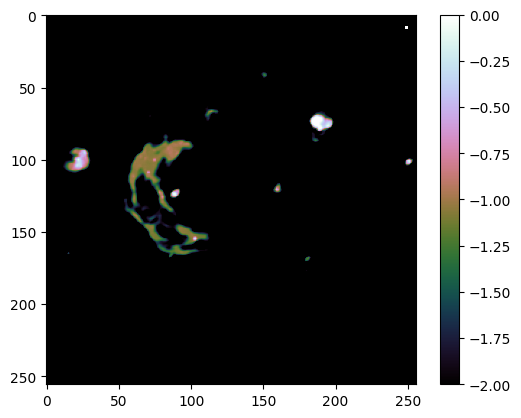

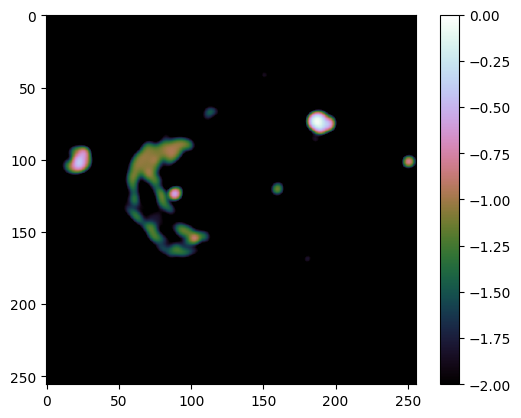

In [193]:
plt.figure()
# plt.imshow(filtered_image)
plt.imshow(np.log10(np.abs(x_map)), cmap=cmap, vmax=0, vmin=-2)
plt.colorbar()
plt.show()


plt.figure()
# plt.imshow(filtered_image)
plt.imshow(np.log10(np.abs(to_numpy(gauss_blurred_im))), cmap=cmap, vmax=0, vmin=-2)
plt.colorbar()
plt.show()

